In [6]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import random
import netCDF4 as nc
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats  
from decimal import Decimal

In [14]:
#SINMOD features first :-) 

In [68]:
#Load transformed (SINMOD grid) coral data
#coral_filepath = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_sinmod_grid.parquet'
#coral_filepath = '/cluster/home/maikents/midnor_total_coral_data_processed_v2.parquet'
coral_filepath = '/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/midnor_total_coral_data_processed.parquet'
coral_data = pd.read_parquet(coral_filepath)

coral_x = coral_data['x']/800
coral_y = coral_data['y']/800

In [69]:
print(coral_x)

0      705.071986
1      612.382990
2      528.253587
3      637.382104
4      585.725195
          ...    
936    958.126173
937    956.505492
938    975.319222
939    939.920680
940    957.469769
Name: x, Length: 941, dtype: float64


In [3]:
#Load SINMOD data 
filename_sinmod = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

sinmod_data = Dataset(filename_sinmod, 'r')


In [33]:
#Load data for stat. northness and eastness
filename_jan_jun = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

jan_jun_data = Dataset(filename_jan_jun, 'r')


In [46]:
temperature = xr.open_dataset('/cluster/home/maikents/sinmod_combine_years/temp_bottom_layer.nc')

In [43]:
#Now plot a histogram for a chosen feature at coral data points 

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, jan_jun_data=False, current_aspect_angle=False, generate_random=False):
    
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    #Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            #Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                elif variable_name in ['statistical_eastness', 'statistical_northness']:
                    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                    longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                    theta = longitude_at_point - longitude_of_projection_origin
                    eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                    northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                    aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                    if variable_name == 'statistical_eastness':
                        value = np.sin(aspect)
                    else:
                        value = np.cos(aspect)
                        
                elif variable_name == 'current_aspect_angle':
                    try:
                        value = current_aspect_angle.variables[int(y), int(x)]
                    except KeyError:
                        value = np.nan  

                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))

    #Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    #Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    #Plot histogram of the combined variable values

    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_coral_points.png')
 

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        #Plotting histogram at random locations
        
        no_points = 100000

        #Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    random_depth = random.uniform(100, depth_at_point)
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                    elif variable_name in ['statistical_eastness', 'statistical_northness']:
                        longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                        longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                        if variable_name == 'statistical_eastness':
                            value = np.sin(aspect)
                        else:
                            value = np.cos(aspect)
                            
                    elif variable_name == 'current_aspect_angle':
                        try:
                            value = current_aspect_angle.variables[int(y), int(x)]
                        except KeyError:
                            value = np.nan  
                       
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        #Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        #Flatten the array to combine all time steps
        random_values_flat = random_values.copy().flatten()

        #Plot histogram at random points
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}', fontsize = 14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.show()
        #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_random_points.png')

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        #Calculate statistics for coral values
        stats = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10),
            'std': np.std(coral_values_flat, ddof=1), #std
            'cv': np.std(coral_values_flat, ddof=1) / np.mean(coral_values_flat) if np.mean(coral_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for coral values: {stats}")


        #Histogram of coral and random points combined
        bin_edges = np.histogram_bin_edges(np.concatenate([random_values_flat, coral_values_flat]), bins=40)
        plt.figure(figsize=(10, 6))
        plt.hist(random_values_flat, bins=bin_edges, edgecolor='black', color='red', alpha=0.6, label='Random Points')
        plt.hist(coral_values_flat, bins=bin_edges, edgecolor='black', color='blue', alpha=0.6, label='Coral Points')
        plt.legend(loc='upper right')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Frequency', fontsize=14) 
        plt.title(f'Combined Histogram of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()


        #KDE line plots for both random and coral points combined
        plt.figure(figsize=(10, 6))
        sns.kdeplot(random_values_flat, color='red', lw=2, label='Random Points')
        sns.kdeplot(coral_values_flat, color='blue', lw=2, label='Coral Points')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Density', fontsize=14)  
        plt.title(f'KDE of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()
    return coral_values, random_values


In [53]:
#Now plot a histogram for a chosen feature at coral data points 

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, generate_random=False):
    
    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = 800

    t_start, t_stop = t_range

    coral_values = []
    valid_coordinates = []
    valid_mask = ~netcdf_data[variable_name].isnull().all(dim='time')
    netcdf_data[variable_name] = netcdf_data[variable_name].where(valid_mask)


    for time in range(t_start, t_stop):

        xc_vals = np.array(netcdf_data.variables['xc'][:])
        yc_vals = np.array(netcdf_data.variables['yc'][:])

        for x_real, y_real in zip(coral_data['x'], coral_data['y']):
            x_idx = np.argmin(np.abs(xc_vals - x_real))
            y_idx = np.argmin(np.abs(yc_vals - y_real))
        
            if 0 <= x_idx < xc_max and 0 <= y_idx < yc_max:
                value = netcdf_data.variables[variable_name][time, y_idx, x_idx]

                coral_values.append(value)
                valid_coordinates.append((int(x_idx), int(y_idx)))

    coral_values = np.array(coral_values)

    coral_values_flat = coral_values.flatten()

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        
        no_points = len(valid_coordinates)/(t_stop - t_start)

        data_2d = netcdf_data[variable_name].isel(time=0) 
        valid_mask = ~np.isnan(data_2d.values)  
        valid_xc_yc_indices = np.argwhere(valid_mask)
        
        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=int(no_points), replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    value = netcdf_data.variables[variable_name][time, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        random_values = np.array(random_values)

        random_values_flat = random_values.copy().flatten()

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        #Calculate statistics for coral values
        stats_coral = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10),
            'std': np.std(coral_values_flat, ddof=1), #std
            'cv': np.std(coral_values_flat, ddof=1) / np.mean(coral_values_flat) if np.mean(coral_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for coral values: {stats_coral}")
         #Calculate statistics for randomvalues
        stats_random = {
            'mean': np.mean(random_values_flat),
            'max': np.max(random_values_flat),
            'min': np.min(random_values_flat),
            '90th_percentile': np.percentile(random_values_flat, 90),
            '10th_percentile': np.percentile(random_values_flat, 10),
            'std': np.std(random_values_flat, ddof=1), #std
            'cv': np.std(random_values_flat, ddof=1) / np.mean(random_values_flat) if np.mean(random_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for randomvalues: {stats_random}")


        # Mann-Whitney U Test
        u_stat, p_value = stats.mannwhitneyu(coral_values_flat, random_values_flat, alternative='two-sided')
        print(f"Mann-Whitney U statistic: {u_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference between coral points and random points is statistically significant (p < 0.05).")
        else:
            print(f"There is no statistically significant difference between coral points and random points (p >= 0.05).")
        
        # Calculate effect size (Cliff’s delta for Mann-Whitney)
        cliff_delta = np.mean(coral_values_flat > np.median(random_values_flat)) - np.mean(random_values_flat > np.median(coral_values_flat))
        print(f"Cliff’s delta: {cliff_delta}")

        # KS Test
        statistic, p_value_ks = stats.ks_2samp(coral_values_flat, random_values_flat)
        print(f"KS Statistic: {statistic}")
        print(f"P-value: {p_value_ks}")
        
        # Interpretation for KS Test
        if p_value_ks < 0.05:
            print("There is a significant difference between the two distributions (ks).")
        else:
            print("There is no significant difference between the two distributions (ks).")

        from scipy.stats import ttest_ind

        # Perform independent t-test
        t_stat, p_value_ttest = ttest_ind(coral_values_flat, random_values_flat)
        
        print(f"T-test statistic: {t_stat}")
        print(f"T-test p-value: {p_value_ttest}")
        
        if p_value_ttest < 0.05:
            print("The difference between coral points and random points is statistically significant (t-test).")
        else:
            print("There is no statistically significant difference between coral points and random points (t-test).")


        
        # Run permutation test
        observed_diff, p_value_permutation = permutation_test(coral_values_flat, random_values_flat)
        p_value_permutation_rounded = Decimal(p_value_permutation)

        
        print(f"Observed Difference in Means: {observed_diff}")
        print(f"Permutation Test p-value: {p_value_permutation_rounded:.20f}")
        
        if p_value_permutation < 0.05:
            print("The difference between coral points and random points is statistically significant (Permutation Test).")
        else:
            print("There is no statistically significant difference between coral points and random points (Permutation Test).")




        from scipy.stats import gaussian_kde

        #plt.figure(figsize=(10, 6))

 
        kde_coral = gaussian_kde(coral_values_flat)
        kde_random = gaussian_kde(random_values_flat)
        x = np.linspace(min(coral_values_flat.min(), random_values_flat.min()),
                        max(coral_values_flat.max(), random_values_flat.max()), 1000)
      
        coral_density = kde_coral(x)
        random_density = kde_random(x)
 
        ratio = coral_density / random_density
        area = np.trapz(ratio, x)
        normalized_ratio = ratio / area
    

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')

        
        plt.plot(x, normalized_ratio, label='Normalized Density Ratio', color='green')
        plt.grid(which='both', linestyle='--', color='gray')

        plt.title(f"KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14) 
        plt.ylabel("Density", fontsize=14)
        plt.legend()
        


        plt.show()

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')
        plt.grid(which='both', linestyle='--', color='gray')
        plt.ylabel("Density", fontsize=14)

        plt.title(f"KDE of Coral Points and Random Points ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14) 
          

        plt.legend()



    return coral_values, random_values


In [75]:
def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, generate_random=False):
    
    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    t_start, t_stop = t_range

    coral_values = []
    valid_coordinates = []
    valid_mask = ~netcdf_data[variable_name].isnull().all(dim='time')
    netcdf_data[variable_name] = netcdf_data[variable_name].where(valid_mask)


    for time in range(t_start, t_stop):

        xc_vals = np.array(netcdf_data.variables['xc'][:])
        yc_vals = np.array(netcdf_data.variables['yc'][:])

        for x_real, y_real in zip(coral_data['x']/800, coral_data['y']/800):
            x_idx = np.argmin(np.abs(xc_vals - x_real))
            y_idx = np.argmin(np.abs(yc_vals - y_real))
        
            if 0 <= x_idx < xc_max and 0 <= y_idx < yc_max:
                value = netcdf_data.variables[variable_name][time, y_idx, x_idx]

                coral_values.append(value)
                valid_coordinates.append((int(x_idx), int(y_idx)))

    coral_values = np.array(coral_values).flatten()  # Flatten the coral values

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        
        no_points = len(valid_coordinates)/(t_stop - t_start)

        data_2d = netcdf_data[variable_name].isel(time=0) 
        valid_mask = ~np.isnan(data_2d.values)  
        valid_xc_yc_indices = np.argwhere(valid_mask)
        
        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=int(no_points), replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    value = netcdf_data.variables[variable_name][time, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        random_values = np.array(random_values).flatten()  # Flatten the random values

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        # Calculate statistics for coral values
        stats_coral = {
            'mean': np.mean(coral_values),
            'max': np.max(coral_values),
            'min': np.min(coral_values),
            '90th_percentile': np.percentile(coral_values, 90),
            '10th_percentile': np.percentile(coral_values, 10),
            'std': np.std(coral_values, ddof=1), #std
            'cv': np.std(coral_values, ddof=1) / np.mean(coral_values) if np.mean(coral_values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for coral values: {stats_coral}")

        # Calculate statistics for random values
        stats_random = {
            'mean': np.mean(random_values),
            'max': np.max(random_values),
            'min': np.min(random_values),
            '90th_percentile': np.percentile(random_values, 90),
            '10th_percentile': np.percentile(random_values, 10),
            'std': np.std(random_values, ddof=1), #std
            'cv': np.std(random_values, ddof=1) / np.mean(random_values) if np.mean(random_values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for random values: {stats_random}")

        # Mann-Whitney U Test
        u_stat, p_value = stats.mannwhitneyu(coral_values, random_values, alternative='two-sided')
        print(f"Mann-Whitney U statistic: {u_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference between coral points and random points is statistically significant (p < 0.05).")
        else:
            print(f"There is no statistically significant difference between coral points and random points (p >= 0.05).")

        # KS Test
        statistic, p_value_ks = stats.ks_2samp(coral_values, random_values)
        print(f"KS Statistic: {statistic}")
        print(f"P-value: {p_value_ks}")

        # Interpretation for KS Test
        if p_value_ks < 0.05:
            print("There is a significant difference between the two distributions (ks).")
        else:
            print("There is no significant difference between the two distributions (ks).")

        from scipy.stats import ttest_ind

        # Perform independent t-test
        t_stat, p_value_ttest = ttest_ind(coral_values, random_values)
        
        print(f"T-test statistic: {t_stat}")
        print(f"T-test p-value: {p_value_ttest}")
        
        if p_value_ttest < 0.05:
            print("The difference between coral points and random points is statistically significant (t-test).")
        else:
            print("There is no statistically significant difference between coral points and random points (t-test).")

        # Plot histograms
        plt.figure(figsize=(10, 6))
        plt.hist(coral_values, bins=20, alpha=0.5, label='Coral Values', color='blue')
        plt.hist(random_values, bins=20, alpha=0.5, label='Random Values', color='red')
        plt.xlabel(f'{variable_name}', fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.legend()
        plt.title(f"Histogram of Coral and Random Values ({variable_name})", fontsize=16)
        plt.grid(True)
        plt.show()

    return coral_values, random_values


In [51]:
t_range = 0,10

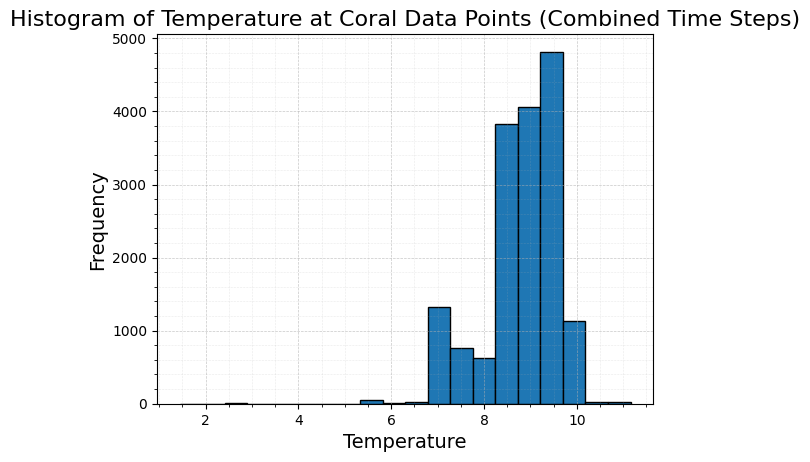

Number of valid coordinates: 836.0 out of 1718


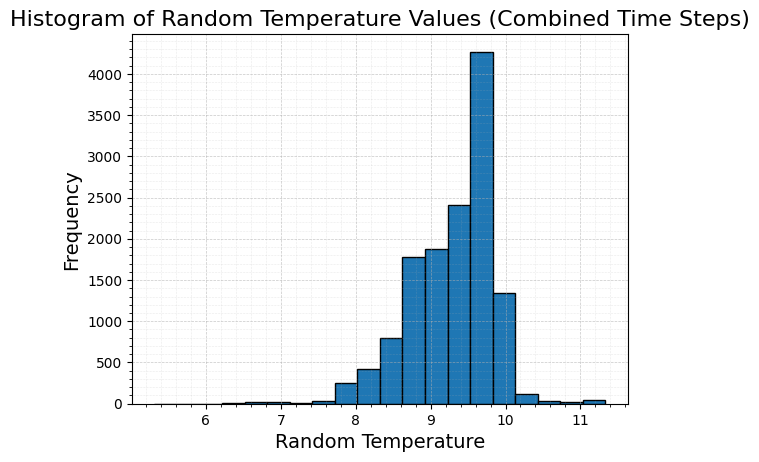

Number of valid random coordinates: 672.1 out of 1718
Statistics for coral values: {'mean': np.float32(8.807966), 'max': np.float32(11.155919), 'min': np.float32(1.4389477), '90th_percentile': np.float32(9.649098), '10th_percentile': np.float32(7.44084), 'std': np.float32(0.8146678), 'cv': np.float32(0.09249216)}


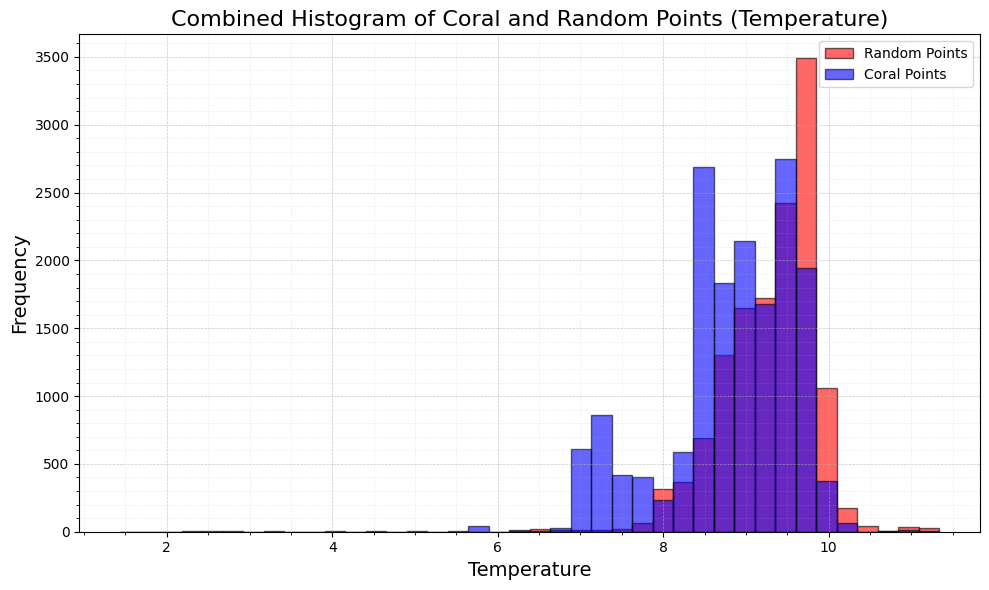

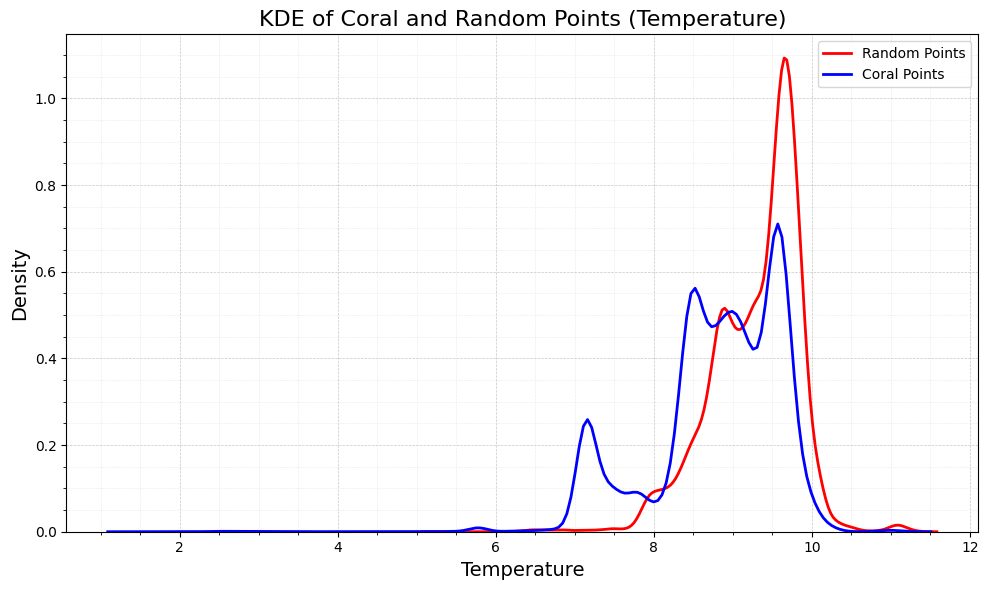

In [44]:
#Plot histograms for desired features
#tmax = len(sinmod_data.variables['time'])
#tmax = 20

#coral_values_salinity, random_values_salinity = plot_histogram_at_coral_points(sinmod_data, coral_data, 'salinity', (0, tmax), False, False, True)
#coral_values_stat_north, random_values_stat_northness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_northness', (0, tmax), jan_jun_data, False, True)
#coral_values_stat_eastness, random_values_stat_eastness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_eastness', (0, tmax), jan_jun_data, False, True)
#coral_values_current_speed, random_values_current_speed = plot_histogram_at_coral_points(sinmod_data, coral_data, 'current_speed', (0, tmax), False, False, True)
coral_values_temperature, random_values_temperature = plot_histogram_at_coral_points(sinmod_data, coral_data, 'temperature', (0, tmax), False, False, True)



In [40]:
#Box plots 
def plot_comparison_boxplots(coral_values, random_values, variable_name):
    
    data = [coral_values, random_values]
    labels = ['Coral Values', 'Random Values']

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, tick_labels=labels)
    plt.xticks(fontsize=14) 
    plt.ylabel(variable_name.capitalize(), fontsize=14)
    plt.title(f'Comparison of {variable_name.capitalize()} at Coral Data Points and Random Locations', fontsize=16)
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Control grid appearance
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/boxplots/{variable_name}_comparison_boxplot.png')
    plt.show()


In [ ]:
#Plot boxplots for desired features
#plot_comparison_boxplots(coral_values_salinity, random_values_salinity, 'salinity')
#plot_comparison_boxplots(coral_values_stat_north, random_values_stat_north, 'statistical_northness')
#plot_comparison_boxplots(coral_values_stat_eastness, random_values_stat_eastness, 'statistical_eastness')
#plot_comparison_boxplots(coral_values_current_speed, random_values_current_speed, 'current_speed')
#plot_comparison_boxplots(coral_values_temperature, random_values_temperature, 'temperature')

In [ ]:
#Next EMOD features

In [7]:
#Load transformed (EMOD grid) coral data
coral_filepath_emod = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_emod_grid.parquet'
coral_data_emod = pd.read_parquet(coral_filepath_emod)

coral_x_emod = coral_data_emod['x']
coral_y_emod = coral_data_emod['y']

In [80]:
print(coral_data_emod.head())

               x             y
0  541563.035108  7.183257e+06
1  574769.093767  7.053834e+06
2  448510.482064  7.072666e+06
3  518562.649871  7.129859e+06
4  475671.223693  7.111198e+06


In [25]:
sinmod_data = xr.open_dataset("/cluster/home/maikents/sinmod_features_masters/sinmod_bottom_features_emod_grid.nc")
sinmod_data_copy = sinmod_data.copy()

In [29]:
print(sinmod_data_copy['bottom_temperature_sundahl_features']['stat'])

<xarray.DataArray 'stat' (stat: 5)> Size: 400B
array(['10th_percentile', '90th_percentile', 'max_(mean_oct_dec)', 'mean',
       'min_(mean_march_may)'], dtype='<U20')
Coordinates:
  * stat     (stat) <U20 400B '10th_percentile' ... 'min_(mean_march_may)'


In [30]:
temp_sundahl = sinmod_data_copy['bottom_temperature_sundahl_features']

In [31]:
temp_sundahl = temp_sundahl.sel(stat='mean')

In [ ]:
temp_sundahl_df = temp_sundahl.to_dataframe()

In [32]:
print(temp_sundahl)

<xarray.DataArray 'bottom_temperature_sundahl_features' (y: 9668, x: 8319)> Size: 322MB
[80428092 values with dtype=float32]
Coordinates:
    stat     <U20 80B 'mean'
  * x        (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.914e+05 6.915e+05
  * y        (y) float64 77kB 7.539e+06 7.539e+06 ... 6.66e+06 6.659e+06
Attributes:
    grid_mapping:  spatial_ref


In [9]:
sinmod_data_copy = sinmod_data_copy.sel(stat='mean')

In [14]:
sinmod_df = sinmod_data_copy.to_dataframe()
sinmod_df = sinmod_df.reset_index()
sinmod_df['y'] = sinmod_df['y'].round().astype(int)
sinmod_df['x'] = sinmod_df['x'].round().astype(int)
sinmod_df = sinmod_df.set_index(['y', 'x'])
nan_indices = sinmod_df[sinmod_df['bottom_temperature_features'].isna()].index
sinmod_df_cleaned = sinmod_df.dropna(subset=['bottom_temperature_features'])
sinmod_df = sinmod_df_cleaned.sort_values(by="y")

In [16]:
sinmod_df.drop('stat', axis=1, inplace=True)

In [18]:
sinmod_df.drop('spatial_ref', axis=1, inplace=True)

In [19]:
print(sinmod_df)

                bottom_temperature_sundahl_features  \
y       x                                             
6659491 274429                                  NaN   
        274338                                  NaN   
6659582 274429                                  NaN   
        274520                                  NaN   
        274247                                  NaN   
...                                             ...   
7539006 439867                                  NaN   
7539097 439958                                  NaN   
        439867                                  NaN   
        440049                                  NaN   
7539188 439958                                  NaN   

                bottom_temperature_features  bottom_salinity_features  \
y       x                                                               
6659491 274429                     9.258629                 34.892754   
        274338                     9.258629                 34.89

In [14]:
#Load EMOD data
#emod_data = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/EMOD_features.nc")
emod_data = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc")
emod_data_copy = emod_data.copy()

In [3]:
print(list(emod_data_copy.variables))

['x', 'y', 'aspect_cos', 'aspect_sin', 'bathymetry_32N_Clip_sample', 'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness_1', 'slope']


In [15]:
#Handle the EMOD data 
emod_df = emod_data_copy.to_dataframe()
emod_df = emod_df.reset_index()
emod_df['y'] = emod_df['y'].round().astype(int)
emod_df['x'] = emod_df['x'].round().astype(int)
emod_df = emod_df.set_index(['y', 'x'])
nan_indices = emod_df[emod_df['bathymetry_32N_Clip_sample'].isna()].index
emod_df_cleaned = emod_df.dropna(subset=['bathymetry_32N_Clip_sample'])
emod_df = emod_df_cleaned.sort_values(by="y")

In [5]:
#Current aspect angle
#sinmod_bottom = xr.open_dataset('/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/SINMOD_bottom_features.nc')
sinmod_bottom = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/ready_for_training/SINMOD_bottom_features_emod_grid2.nc")

current_aspect_angle = sinmod_bottom['current_aspect_angle']

In [6]:
current_df = current_aspect_angle.to_dataframe()

In [7]:
current_df_cleaned = current_df.dropna(subset=['current_aspect_angle'])


In [33]:
print(current_df_cleaned)

                current_aspect_angle
y       x                           
7539097 439867             11.501816
        439958             16.181029
        440049             26.574801
7539006 439867             37.366278
        439958             37.872374
...                              ...
6659309 274611             20.341295
        274702             22.101466
        274793             82.475902
6659218 274611             31.833423
        274702             55.508681

[33376001 rows x 1 columns]


In [8]:
chlor_a_sinmod = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/surface_chlorophyll_2019_2022_2023_features_emod_grid.nc')

In [56]:
print(chlor_a_sinmod)

<xarray.Dataset> Size: 966MB
Dimensions:           (stat: 3, x: 8325, y: 9671)
Coordinates:
  * stat              (stat) <U15 180B 'mean' ... '90th_percentile'
  * x                 (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.92e+05
  * y                 (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06
Data variables:
    spatial_ref       int64 8B ...
    chlor_a_features  (stat, y, x) float32 966MB ...


In [9]:
chlor_a_sinmod= chlor_a_sinmod['chlor_a_features'].isel(stat=0)

In [10]:
chlor_a_sinmod_df = chlor_a_sinmod.to_dataframe()

In [11]:
chlor_a_sinmod_df.drop('stat', axis=1, inplace=True)


In [64]:
print(chlor_a_sinmod_df)

                             chlor_a_features
y            x                               
7.539188e+06 -65456.088686                NaN
             -65365.088686                NaN
             -65274.088686                NaN
             -65183.088686                NaN
             -65092.088686                NaN
...                                       ...
6.659218e+06  691663.911314               NaN
              691754.911314               NaN
              691845.911314               NaN
              691936.911314               NaN
              692027.911314               NaN

[80511075 rows x 1 columns]


In [12]:
chlor_a_sinmod_df_cleaned = chlor_a_sinmod_df.dropna(subset=['chlor_a_features'])

In [3]:
chlor_a_satellite = xr.open_dataset('/cluster/home/maikents/satellite_data/chlor_a_dataset_midnor_features_emod_grid.nc')

In [4]:
print(chlor_a_satellite)

<xarray.Dataset> Size: 2GB
Dimensions:       (y: 9671, x: 8325)
Coordinates:
    spatial_ref   int64 8B ...
  * x             (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.919e+05 6.92e+05
  * y             (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06 6.659e+06
Data variables:
    chlor_a_mean  (y, x) float32 322MB ...
    chlor_a_min   (y, x) float64 644MB ...
    chlor_a_max   (y, x) float64 644MB ...


In [5]:
chlor_a_satellite = chlor_a_satellite['chlor_a_mean']

In [6]:
chlor_a_satellite_df = chlor_a_satellite.to_dataframe()

In [7]:
chlor_a_satellite_df_cleaned = chlor_a_satellite_df.dropna(subset=['chlor_a_mean'])

In [8]:
chlor_a_satellite_df_cleaned.drop('spatial_ref', axis=1, inplace=True)


/tmp/ipykernel_851578/4054683248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chlor_a_satellite_df_cleaned.drop('spatial_ref', axis=1, inplace=True)


In [9]:
print(chlor_a_satellite_df_cleaned)

                            chlor_a_mean
y            x                          
7.539188e+06 37828.911314       0.507508
             37919.911314       0.507618
             38010.911314       0.507728
             38101.911314       0.507837
             38192.911314       0.507947
...                                  ...
6.659218e+06 566902.911314      0.283373
             566993.911314      0.283373
             567084.911314      0.283373
             567175.911314      0.283373
             567266.911314      0.283373

[57083337 rows x 1 columns]


In [20]:
def permutation_test(x, y, num_permutations=100000):
    observed_diff = np.mean(x) - np.mean(y)
    combined = np.concatenate([x, y])
    count = 0

    #Perform permutations
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        new_diff = np.mean(new_x) - np.mean(new_y)
        if abs(new_diff) >= abs(observed_diff):
            count += 1
    
    p_value_permutation = count / num_permutations
    return observed_diff, p_value_permutation

In [21]:
#Histograms for EMOD data

def plot_histogram_at_coral_points_emod(emod_df, coral_data, variable_name, generate_random=False):
    
    coral_values = []
    valid_coords = []
    xc_max = 692028
    yc_max = 7539188
    x_indices = np.clip(np.round(coral_data['x']).astype(int), -65456, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y']).astype(int), 6659218, yc_max - 1)

    emod_df.index = emod_df.index.map(lambda index: (round(index[0]), round(index[1])))

    df_y_values = np.array(emod_df.index.get_level_values(0))
    df_x_values = np.array(emod_df.index.get_level_values(1))

    for x, y in zip(x_indices, y_indices):
    
        if (y, x) in emod_df.index:
            closest_y, closest_x = y, x
        else:
            # Find the closest available indices in df
            closest_y = df_y_values[np.abs(df_y_values - y).argmin()]
            closest_x = df_x_values[np.abs(df_x_values - x).argmin()]

        if (closest_y, closest_x) in emod_df.index:
            value = emod_df.loc[(closest_y, closest_x)][variable_name]
            if not np.ma.is_masked(value):
                if (closest_y, closest_x) not in valid_coords:
                    coral_values.append(value)
                    valid_coords.append((closest_y, closest_x))

    coral_values_flat = np.ravel(coral_values)
    values = pd.DataFrame({f'{variable_name}': coral_values_flat})
    

    values = values[variable_name].dropna().values

    print(f"Number of valid coordinates: {len(valid_coords)} out of {len(coral_data)}")

    if len(values) == 0:
        print("Error: array is empty after dropping NaNs!")
    else:

        #Calculate statistics for coral values
        stats_coral = {
            'mean': np.mean(values),
            'max': np.max(values),
            'min': np.min(values),
            '90th_percentile': np.percentile(values, 90),
            '10th_percentile': np.percentile(values, 10),
            'std': np.std(values, ddof=1), #std
            'cv': np.std(values, ddof=1) / np.mean(values) if np.mean(values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }
       
        print(f"Statistics for {variable_name}:", stats_coral)


    if generate_random:
        no_points = int(len(values))  

        variable_data = emod_df[variable_name]
        valid_data = variable_data.dropna()
        random_indices = np.random.choice(valid_data.index, no_points, replace=False)
        random_values = emod_df.loc[random_indices, variable_name]

        #Calculate statistics for coral values
        random_stats = {
            'mean': np.mean(random_values),
            'max': np.max(random_values),
            'min': np.min(random_values),
            '90th_percentile': np.percentile(random_values, 90),
            '10th_percentile': np.percentile(random_values, 10),
            'std': np.std(random_values, ddof=1), #std
            'cv': np.std(random_values, ddof=1) / np.mean(random_values) if np.mean(random_values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for random values: {random_stats}")
        
        # Mann-Whitney U Test
        u_stat, p_value = stats.mannwhitneyu(values, random_values, alternative='two-sided')
        print(f"Mann-Whitney U statistic: {u_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference between coral points and random points is statistically significant (p < 0.05).")
        else:
            print(f"There is no statistically significant difference between coral points and random points (p >= 0.05).")
        
        # Calculate effect size (Cliff’s delta for Mann-Whitney)
        cliff_delta = np.mean(values > np.median(random_values)) - np.mean(random_values > np.median(values))
        print(f"Cliff’s delta: {cliff_delta}")

        # KS Test
        statistic, p_value_ks = stats.ks_2samp(values, random_values)
        print(f"KS Statistic: {statistic}")
        print(f"P-value: {p_value_ks}")
        
        # Interpretation for KS Test
        if p_value_ks < 0.05:
            print("There is a significant difference between the two distributions (ks).")
        else:
            print("There is no significant difference between the two distributions (ks).")

        from scipy.stats import ttest_ind

        # Perform independent t-test
        t_stat, p_value_ttest = ttest_ind(values, random_values)
        
        print(f"T-test statistic: {t_stat}")
        print(f"T-test p-value: {p_value_ttest}")
        
        if p_value_ttest < 0.05:
            print("The difference between coral points and random points is statistically significant (t-test).")
        else:
            print("There is no statistically significant difference between coral points and random points (t-test).")


        
        # Run permutation test
        observed_diff, p_value_permutation = permutation_test(values, random_values)
        p_value_permutation_rounded = Decimal(p_value_permutation)

        
        print(f"Observed Difference in Means: {observed_diff}")
        print(f"Permutation Test p-value: {p_value_permutation_rounded:.20f}")
        
        if p_value_permutation < 0.05:
            print("The difference between coral points and random points is statistically significant (Permutation Test).")
        else:
            print("There is no statistically significant difference between coral points and random points (Permutation Test).")



        from scipy.stats import gaussian_kde

        #plt.figure(figsize=(10, 6))

 
        kde_coral = gaussian_kde(values)
        kde_random = gaussian_kde(random_values)

        x = np.linspace(min(values.min(), random_values.min()),
                        max(values.max(), random_values.max()), 1000)
         
        coral_density = kde_coral(x)
        random_density = kde_random(x)
   
        from scipy.stats import gaussian_kde

        #plt.figure(figsize=(10, 6))

 
        kde_coral = gaussian_kde(values)
        kde_random = gaussian_kde(random_values)
        x = np.linspace(min(values.min(), random_values.min()),
                        max(values.max(), random_values.max()), 1000)
      
        coral_density = kde_coral(x)
        random_density = kde_random(x)
        """
        if variable_name=='broad_BPI_std':
            mask = (x >= -500) & (x <= 375)
            #coral_density_2 = np.where(mask, coral_density, 0)
            ratio = np.where(mask,
                 coral_density / random_density,
                 0)
        elif variable_name=='fine_BPI_std':
            mask = (x >= -500) & (x <= 500)
            #coral_density_2 = np.where(mask, coral_density, 0)
            ratio = np.where((mask,
                 coral_density / random_density,
                 0)
        else:
            ratio = np.where((random_density > 0),
                     coral_density / random_density,
                     0)
        """
        ratio = coral_density / random_density
        area = np.trapz(ratio, x)
        normalized_ratio = ratio / area
    

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')

        
        plt.plot(x, normalized_ratio, label='Normalized Density Ratio', color='green')
        plt.grid(which='both', linestyle='--', color='gray')


        """
        if emod_df is chlor_a_satellite_df_cleaned:
            plt.title("KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio (Chlorophyll-a, satellite)", fontsize=16)
            plt.xlabel('Chlorophyll-a, satellite', fontsize=14)
        elif emod_df is chlor_a_sinmod_df_cleaned:
            plt.title("KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio (Chlorophyll-a, SINMOD)", fontsize=16)
            plt.xlabel('Chlorophyll-a, SINMOD', fontsize=14)
        else:
            plt.title(f"KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio ({variable_name})", fontsize=16)
            plt.xlabel(f'{variable_name}', fontsize=14) 
            
        """
        plt.title(f"KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14) 
        plt.ylabel("Density", fontsize=14)
        plt.legend()
        


        plt.show()

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')
        plt.grid(which='both', linestyle='--', color='gray')
        plt.ylabel("Density", fontsize=14)
        """
        if emod_df is chlor_a_satellite_df_cleaned:
            plt.title("KDE of Coral Points and Random Points (Chlorophyll-a, satellite)", fontsize=16)
            plt.xlabel('Chlorophyll-a, satellite', fontsize=14)
        elif emod_df is chlor_a_sinmod_df_cleaned:
            plt.title("KDE of Coral Points and Random Points (Chlorophyll-a, SINMOD)", fontsize=16)
            plt.xlabel('Chlorophyll-a, SINMOD', fontsize=14)
        
        else:
            plt.title(f"KDE of Coral Points and Random Points ({variable_name})", fontsize=16)
            plt.xlabel(f'{variable_name}', fontsize=14) 
        """
        plt.title(f"KDE of Coral Points and Random Points ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14) 
          

        plt.legend()







        

      


    return values, random_values




In [23]:
values_temperature, random_values_temperature = plot_histogram_at_coral_points_emod(sinmod_df, coral_data_emod, 'bottom_temperature_features',True)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x145c2d2bd0d0>>
Traceback (most recent call last):
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [24]:
values_temperature_sundahl, random_values_temperature_sundahl = plot_histogram_at_coral_points_emod(sinmod_df, coral_data_emod, 'bottom_temperature_sundahl_features',True)


Number of valid coordinates: 712 out of 841
Error: array is empty after dropping NaNs!


IndexError: index -1 is out of bounds for axis 0 with size 0

In [25]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_histogram_at_coral_points_and_all_points_emod(emod_df, coral_data, variable_name, generate_random=False):
    
    coral_values = []
    valid_coords = []
    xc_max = 692028
    yc_max = 7539188
    x_indices = np.clip(np.round(coral_data['x']).astype(int), -65456, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y']).astype(int), 6659218, yc_max - 1)

    # Adjust dataframe indices for searching
    emod_df.index = emod_df.index.map(lambda index: (round(index[0]), round(index[1])))
    df_y_values = np.array(emod_df.index.get_level_values(0))
    df_x_values = np.array(emod_df.index.get_level_values(1))

    # Collect coral values
    for x, y in zip(x_indices, y_indices):
        if (y, x) in emod_df.index:
            closest_y, closest_x = y, x
        else:
            # Find the closest available indices in df
            closest_y = df_y_values[np.abs(df_y_values - y).argmin()]
            closest_x = df_x_values[np.abs(df_x_values - x).argmin()]

        if (closest_y, closest_x) in emod_df.index:
            value = emod_df.loc[(closest_y, closest_x)][variable_name]
            if not np.ma.is_masked(value):
                if (closest_y, closest_x) not in valid_coords:
                    coral_values.append(value)
                    valid_coords.append((closest_y, closest_x))

    coral_values_flat = np.ravel(coral_values)
    values = pd.DataFrame({f'{variable_name}': coral_values_flat})
    values = values[variable_name].dropna().values

    # Plot histogram of the combined variable values at coral points
    bin_edges = np.histogram_bin_edges(values, bins=20)
    plt.hist(values, bins=bin_edges, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()

    print(f"Number of valid coral coordinates: {len(valid_coords)} out of {len(coral_data)}")

    # Calculate statistics for coral values
    stats_coral = {
        'mean': np.mean(values),
        'max': np.max(values),
        'min': np.min(values),
        '90th_percentile': np.percentile(values, 90),
        '10th_percentile': np.percentile(values, 10),
        'std': np.std(values, ddof=1),  # Standard deviation
        'cv': np.std(values, ddof=1) / np.mean(values) if np.mean(values) != 0 else np.nan  # Coefficient of Variation
    }
    print(f"Statistics for coral points ({variable_name}):", stats_coral)

    # Collect all model area values (for the entire grid)
    model_values = []
    for y in range(yc_max):
        for x in range(xc_max):
            if (y, x) in emod_df.index:
                value = emod_df.loc[(y, x)][variable_name]
                if not np.ma.is_masked(value):
                    model_values.append(value)

    model_values_flat = np.array(model_values)

    # Plot histogram for all grid points (model area)
    plt.hist(model_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()} (Model Area)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at All Model Points', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()

    print(f"Number of model area coordinates: {len(model_values_flat)}")

    # Calculate statistics for model values
    stats_model = {
        'mean': np.mean(model_values_flat),
        'max': np.max(model_values_flat),
        'min': np.min(model_values_flat),
        '90th_percentile': np.percentile(model_values_flat, 90),
        '10th_percentile': np.percentile(model_values_flat, 10),
        'std': np.std(model_values_flat, ddof=1),  # Standard deviation
        'cv': np.std(model_values_flat, ddof=1) / np.mean(model_values_flat) if np.mean(model_values_flat) != 0 else np.nan  # Coefficient of Variation
    }
    print(f"Statistics for model area points ({variable_name}):", stats_model)

    # Mann-Whitney U Test (to compare coral points vs model area points)
    u_stat, p_value = stats.mannwhitneyu(values, model_values_flat, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {u_stat}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print(f"The difference between coral points and model area points is statistically significant (p < 0.05).")
    else:
        print(f"There is no statistically significant difference between coral points and model area points (p >= 0.05).")

    
    # KDE plot for both coral points and model area points
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, color='blue', lw=2, label='Coral Points')
    sns.kdeplot(model_values_flat, color='green', lw=2, label='Model Area Points')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'KDE of Coral and Model Area Points ({variable_name.capitalize()})', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Return values
    return values, model_values_flat


In [19]:
#Repeat for desired features

#values_chlor_a, random_values_chlor_a = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'chlor_a', chlor_a, True)
values_bathymetry, random_values_bathymetry = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'bathymetry_32N_Clip_sample',True)


KeyboardInterrupt: 

Number of valid coordinates: 718 out of 841
Statistics for aspect_cos: {'mean': np.float64(-0.09288723331703512), 'max': np.float64(0.9999837875366211), 'min': np.float64(-0.999980092048645), '90th_percentile': np.float64(0.9366859555244446), '10th_percentile': np.float64(-0.9724753499031067), 'std': np.float64(0.7232563914769918), 'cv': np.float64(-7.786391796259365)}
Statistics for random values: {'mean': np.float64(0.256231362669618), 'max': np.float64(0.9999943375587463), 'min': np.float64(-0.9999980926513672), '90th_percentile': np.float64(0.9872880697250367), '10th_percentile': np.float64(-0.8521929502487182), 'std': np.float64(0.6689698137450187), 'cv': np.float64(2.610803793786873)}
Mann-Whitney U statistic: 185802.5
p-value: 3.8611090003885266e-19
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: -0.4125874125874126
KS Statistic: 0.24475524475524477
P-value: 3.3292105370504875e-19
There is a significant difference bet

/tmp/ipykernel_2489220/1894955081.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


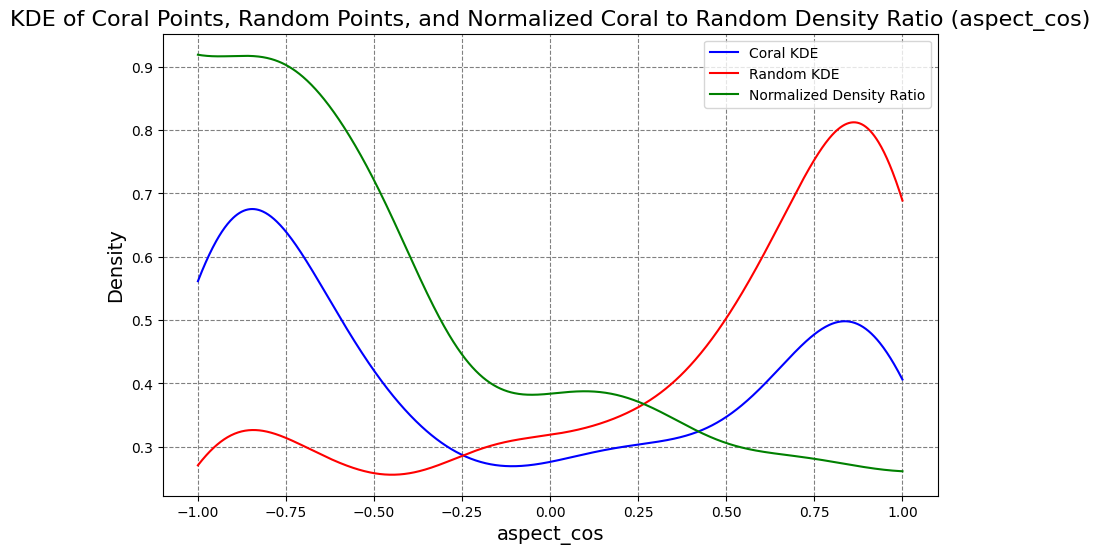

In [17]:
values_aspect_cos, random_values_aspect_cos = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'aspect_cos',True)


In [ ]:

values_temperature, random_values_temperature = plot_histogram_at_coral_points_emod(temperature_df, coral_data, 'temperature',True)


Number of valid coordinates: 718 out of 841
Statistics for aspect_sin: {'mean': np.float64(-0.17915710491499492), 'max': np.float64(1.0), 'min': np.float64(-0.9999998807907104), '90th_percentile': np.float64(0.8340409755706787), '10th_percentile': np.float64(-0.9647203683853149), 'std': np.float64(0.661451741366246), 'cv': np.float64(-3.692020708193998)}
Statistics for random values: {'mean': np.float64(-0.1750123099328696), 'max': np.float64(0.9999927282333374), 'min': np.float64(-0.9999977350234985), '90th_percentile': np.float64(0.8973725080490113), '10th_percentile': np.float64(-0.9752842664718628), 'std': np.float64(0.6851410365921013), 'cv': np.float64(-3.914816259809979)}
Mann-Whitney U statistic: 256670.5
p-value: 0.8922643385707578
There is no statistically significant difference between coral points and random points (p >= 0.05).
Cliff’s delta: -0.02797202797202797
KS Statistic: 0.04755244755244755
P-value: 0.3941895933435158
There is no significant difference between the two

/tmp/ipykernel_2489220/1894955081.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


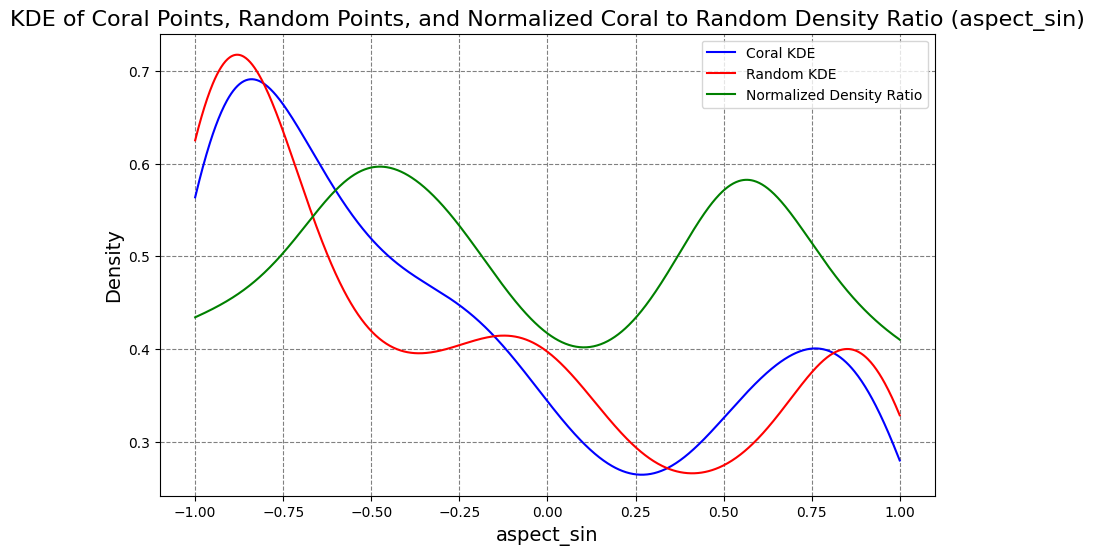

In [18]:
values_aspect_sin, random_values_aspect_sin = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'aspect_sin',True)


In [6]:
values_broad_BPI, random_values_broad_BPI = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'broad_BPI_std', True)

Number of valid coordinates: 718 out of 841
Statistics for broad_BPI_std: {'mean': np.float64(5.747910863509749), 'max': np.float64(574.0), 'min': np.float64(-623.0), '90th_percentile': np.float64(128.20000000000027), '10th_percentile': np.float64(-159.79999999999998), 'std': np.float64(138.07510827667483), 'cv': np.float64(24.021790099988497)}
Statistics for random values: {'mean': np.float64(0.6852367688022284), 'max': np.float64(993.0), 'min': np.float64(-1181.0), '90th_percentile': np.float64(44.900000000000205), '10th_percentile': np.float64(-47.0), 'std': np.float64(108.04990623047885), 'cv': np.float64(157.6825867347232)}
Mann-Whitney U statistic: 310514.0
p-value: 1.8313312473549008e-11
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.394150417827298
KS Statistic: 0.2604456824512535
P-value: 8.295118813173234e-22
There is a significant difference between the two distributions (ks).
T-test statistic: 0.77373753944517

NameError: name 'permutation_test' is not defined

Number of valid coordinates: 718 out of 841
Statistics for fine_BPI_std: {'mean': np.float64(20.764623955431755), 'max': np.float64(1075.0), 'min': np.float64(-834.0), '90th_percentile': np.float64(155.0), '10th_percentile': np.float64(-67.69999999999997), 'std': np.float64(162.85146187619577), 'cv': np.float64(7.8427359063054904)}
Statistics for random values: {'mean': np.float64(-0.22284122562674094), 'max': np.float64(1225.0), 'min': np.float64(-799.0), '90th_percentile': np.float64(23.0), '10th_percentile': np.float64(-23.399999999999977), 'std': np.float64(89.1332222272254), 'cv': np.float64(-399.985334744674)}
Mann-Whitney U statistic: 334658.5
p-value: 9.362268209787571e-24
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.5
KS Statistic: 0.3746518105849582
P-value: 3.0124605539880684e-45
There is a significant difference between the two distributions (ks).
T-test statistic: 3.0292212208533145
T-test p-value: 0.002495

/tmp/ipykernel_2103257/1227468809.py:181: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


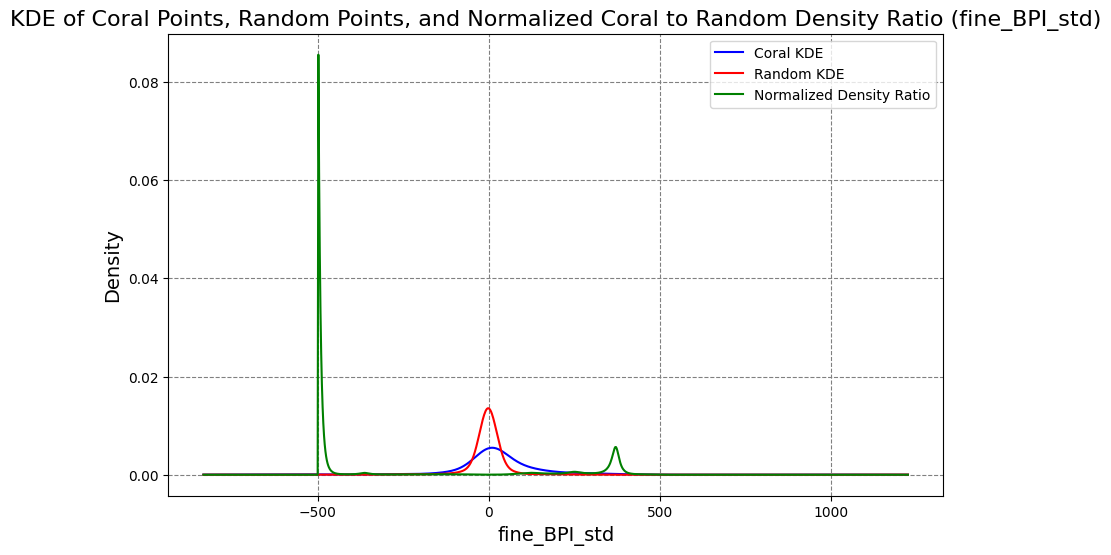

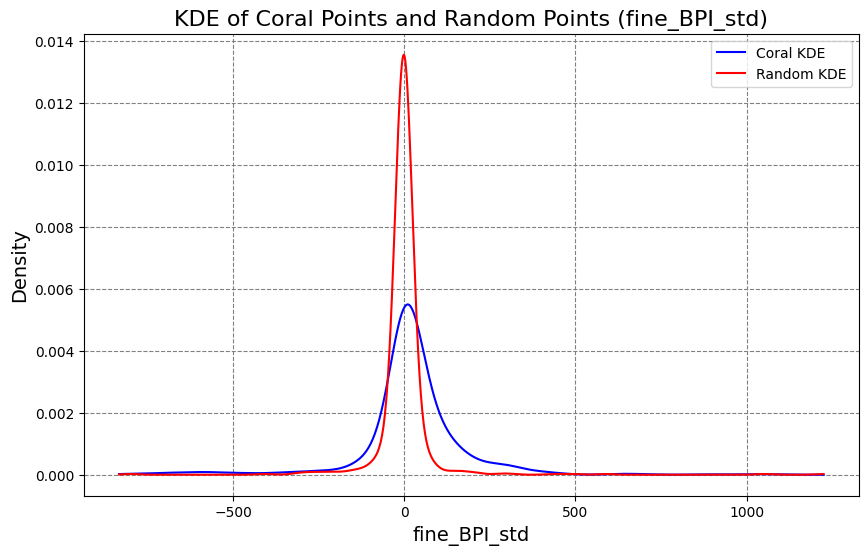

In [29]:
values_fine_BPI, random_values_fine_BPI = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'fine_BPI_std', True)

Number of valid coordinates: 718 out of 841
Statistics for log_ruggedness_1: {'mean': np.float64(-9.3405597123595), 'max': np.float64(0.0), 'min': np.float64(-15.942384719848633), '90th_percentile': np.float64(-5.983283710479736), '10th_percentile': np.float64(-12.820226287841797), 'std': np.float64(2.826955972008207), 'cv': np.float64(-0.302653808664973)}
Statistics for random values: {'mean': np.float32(-10.187145), 'max': np.float32(0.0), 'min': np.float32(-15.942385), '90th_percentile': np.float32(0.0), '10th_percentile': np.float32(-15.026094), 'std': np.float32(4.7583776), 'cv': np.float32(-0.46709627)}
Mann-Whitney U statistic: 330932.0
p-value: 1.2208959892645363e-20
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.49164345403899723
KS Statistic: 0.30362116991643456
P-value: 1.3107703874652136e-29
There is a significant difference between the two distributions (ks).
T-test statistic: 4.098569867315176
T-test p-value

/tmp/ipykernel_2489220/3192146677.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


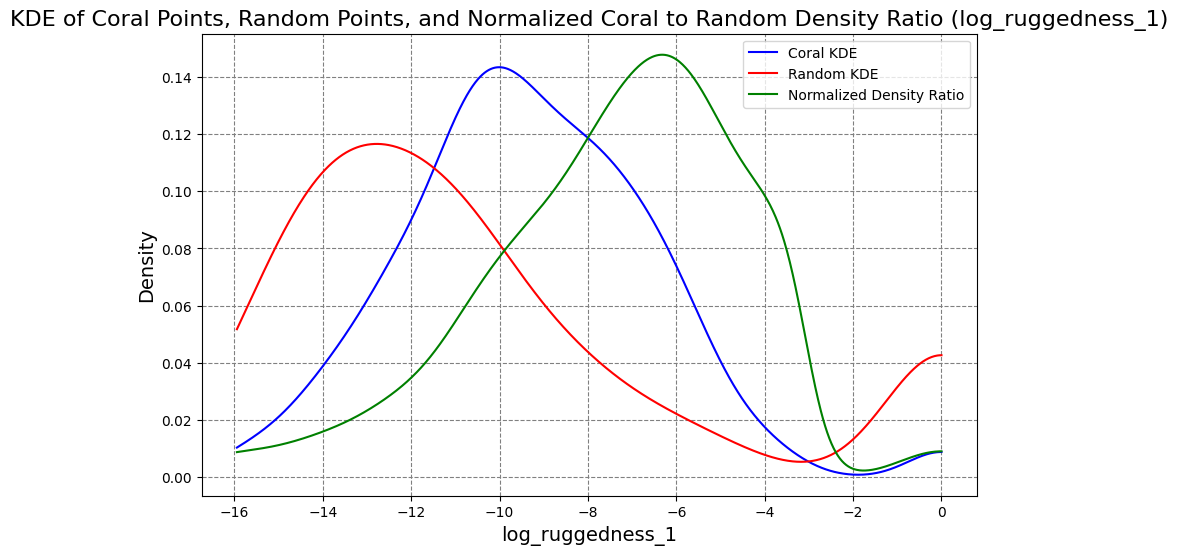

In [25]:
values_log_ruggedness, random_values_log_ruggedness = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'log_ruggedness_1', True)

Number of valid coordinates: 718 out of 841
Statistics for slope: {'mean': np.float64(3.123740909168097), 'max': np.float64(58.217594146728516), 'min': np.float64(0.0), '90th_percentile': np.float64(6.76164999008179), '10th_percentile': np.float64(0.3241235792636871), 'std': np.float64(5.473476216303822), 'cv': np.float64(1.7522183738860395)}
Statistics for random values: {'mean': np.float64(1.354202422525545), 'max': np.float64(23.234968185424805), 'min': np.float64(0.0), '90th_percentile': np.float64(2.620705032348633), '10th_percentile': np.float64(0.11843949854373932), 'std': np.float64(2.7377383564149147), 'cv': np.float64(2.0216610979835044)}
Mann-Whitney U statistic: 357451.5
p-value: 6.965964416854959e-39
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.5482517482517482
KS Statistic: 0.31608391608391606
P-value: 5.776271238538008e-32
There is a significant difference between the two distributions (ks).
T-test statis

/tmp/ipykernel_851578/29793204.py:182: RuntimeWarning: divide by zero encountered in divide
  ratio = coral_density / random_density
/tmp/ipykernel_851578/29793204.py:182: RuntimeWarning: overflow encountered in divide
  ratio = coral_density / random_density
/tmp/ipykernel_851578/29793204.py:183: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)
/tmp/ipykernel_851578/29793204.py:184: RuntimeWarning: invalid value encountered in divide
  normalized_ratio = ratio / area


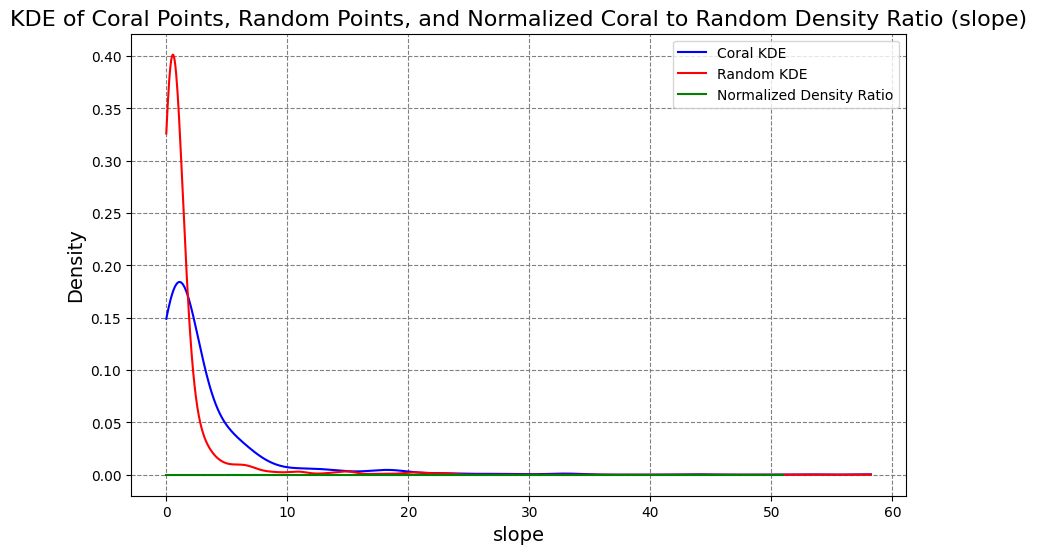

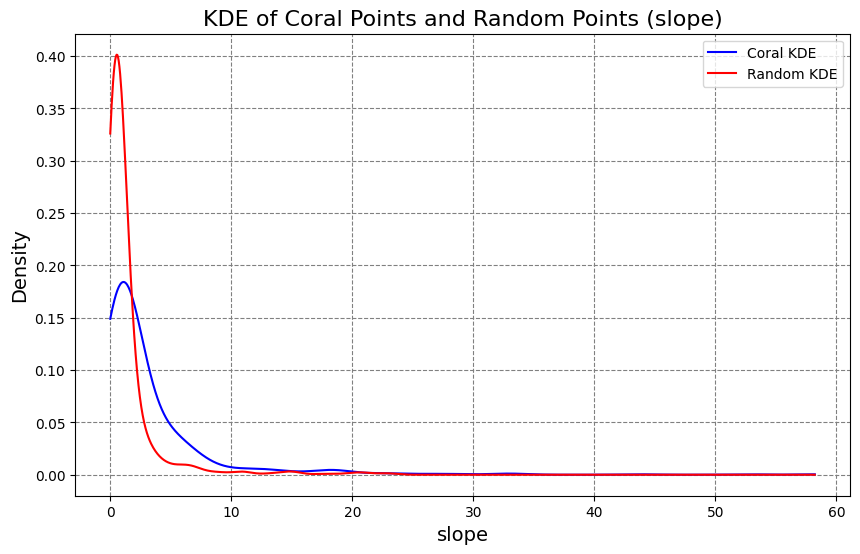

In [18]:
values_slope, random_values_slope = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'slope', True)

Number of valid coordinates: 715 out of 841
Statistics for current_aspect_angle: {'mean': np.float64(49.792551015287), 'max': np.float64(119.04370735908456), 'min': np.float64(0.18736109645549717), '90th_percentile': np.float64(86.68523178229196), '10th_percentile': np.float64(12.047915805344477), 'std': np.float64(27.644093004328667), 'cv': np.float64(0.555185312675415)}
Statistics for random values: {'mean': np.float64(47.97443679358082), 'max': np.float64(125.31950666869831), 'min': np.float64(0.0006484056435726588), '90th_percentile': np.float64(86.57758019978955), '10th_percentile': np.float64(8.881467240736102), 'std': np.float64(28.98726256626725), 'cv': np.float64(0.6042230926230668)}
Mann-Whitney U statistic: 265874.5
p-value: 0.18876450155590252
There is no statistically significant difference between coral points and random points (p >= 0.05).
Cliff’s delta: 0.09650349650349643
KS Statistic: 0.06713286713286713
P-value: 0.07970210430832171
There is no significant difference 

/tmp/ipykernel_2489220/3192146677.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


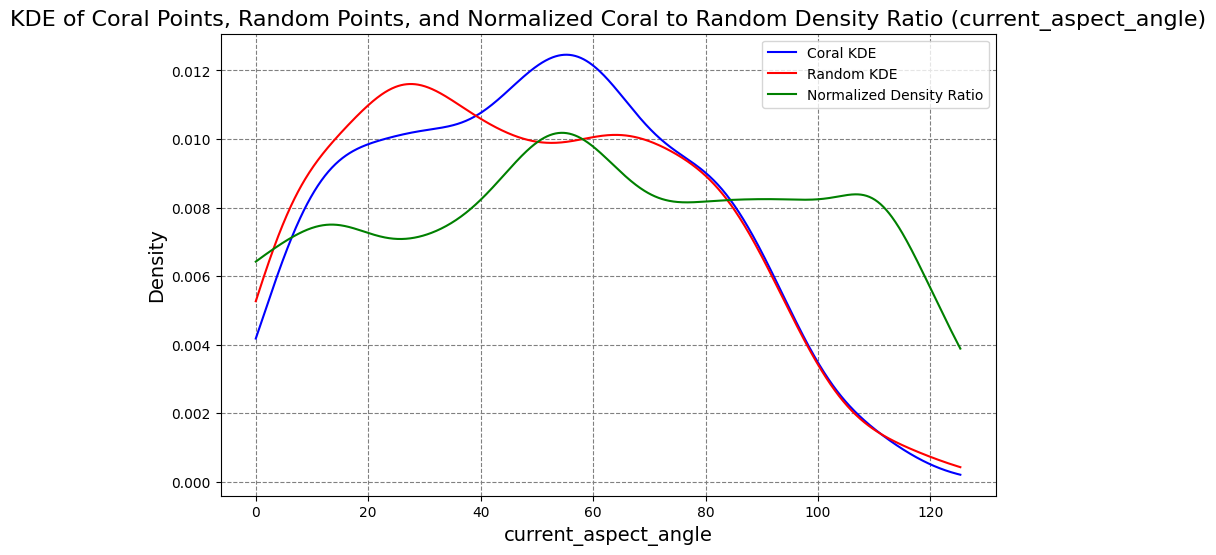

In [26]:
values_current_aspect_angle, random_values_current_aspect_angle= plot_histogram_at_coral_points_emod(current_df_cleaned, coral_data_emod, 'current_aspect_angle', True)

Number of valid coordinates: 711 out of 841
Statistics for chlor_a_mean: {'mean': np.float32(1.2613521), 'max': np.float32(6.008679), 'min': np.float32(0.41023383), '90th_percentile': np.float32(1.5255196), '10th_percentile': np.float32(0.91609746), 'std': np.float32(0.67804515), 'cv': np.float32(0.53755426)}
Statistics for random values: {'mean': np.float32(0.9821064), 'max': np.float32(10.0), 'min': np.float32(0.44261736), '90th_percentile': np.float32(1.227074), '10th_percentile': np.float32(0.65603644), 'std': np.float32(0.6005492), 'cv': np.float32(0.611491)}
Mann-Whitney U statistic: 384086.0
p-value: 1.580710612741832e-64
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.7369901547116736
KS Statistic: 0.46554149085794655
P-value: 5.979820300416068e-70
There is a significant difference between the two distributions (ks).
T-test statistic: 8.220669609219595
T-test p-value: 4.515108407535423e-16
The difference between co

/tmp/ipykernel_851578/3881309931.py:183: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


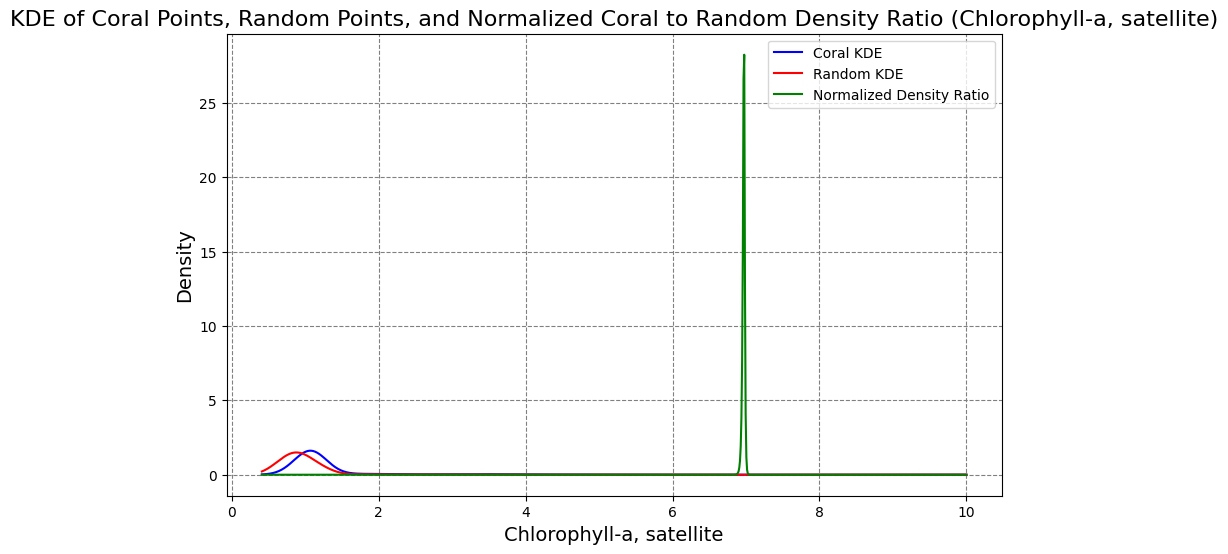

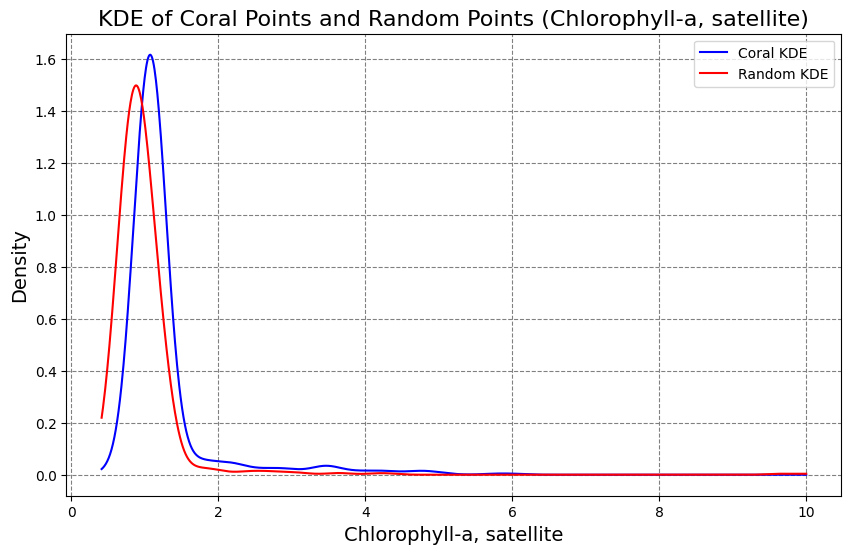

In [12]:
values_chlor_a_satellite, random_values_chlor_a_satellite = plot_histogram_at_coral_points_emod(chlor_a_satellite_df_cleaned, coral_data_emod, 'chlor_a_mean', True)

Number of valid coordinates: 718 out of 841
Statistics for chlor_a_features: {'mean': np.float32(1.7211558), 'max': np.float32(2.1733706), 'min': np.float32(0.82424134), '90th_percentile': np.float32(1.9545237), '10th_percentile': np.float32(1.4944329), 'std': np.float32(0.24937351), 'cv': np.float32(0.14488724)}
Statistics for random values: {'mean': np.float32(1.8132033), 'max': np.float32(2.6242912), 'min': np.float32(0.4282763), '90th_percentile': np.float32(2.1456594), '10th_percentile': np.float32(1.5472621), 'std': np.float32(0.25461304), 'cv': np.float32(0.14042167)}
Mann-Whitney U statistic: 210899.0
p-value: 2.456071438961525e-09
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: -0.16573816155988857
KS Statistic: 0.16016713091922005
P-value: 1.8739032674378473e-08
There is a significant difference between the two distributions (ks).
T-test statistic: -6.920653984784229
T-test p-value: 6.7572936885599535e-12
The diffe

/tmp/ipykernel_2489220/2592831819.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


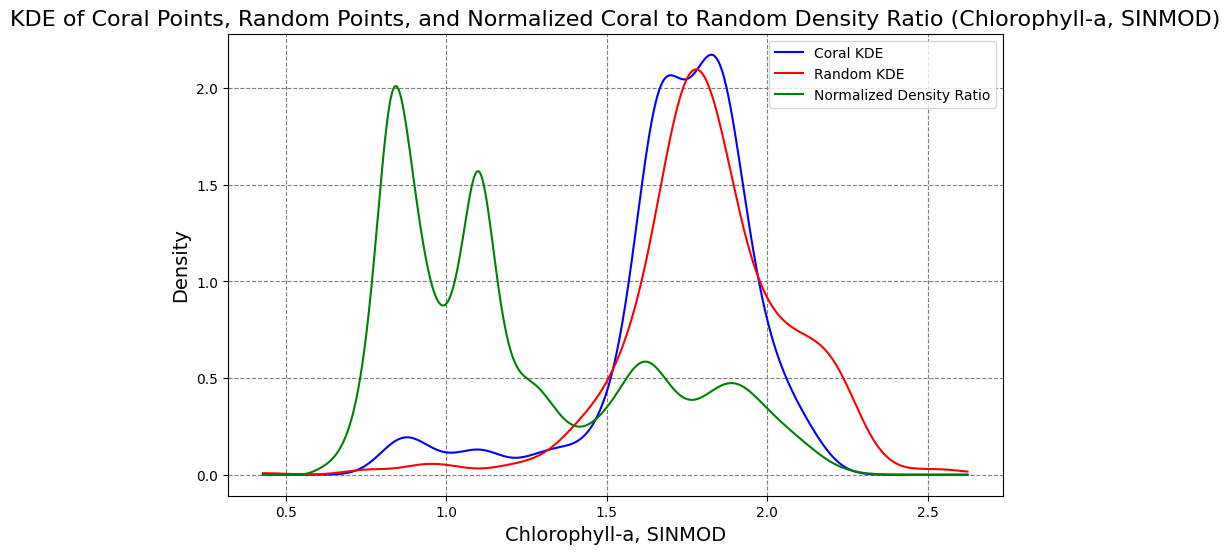

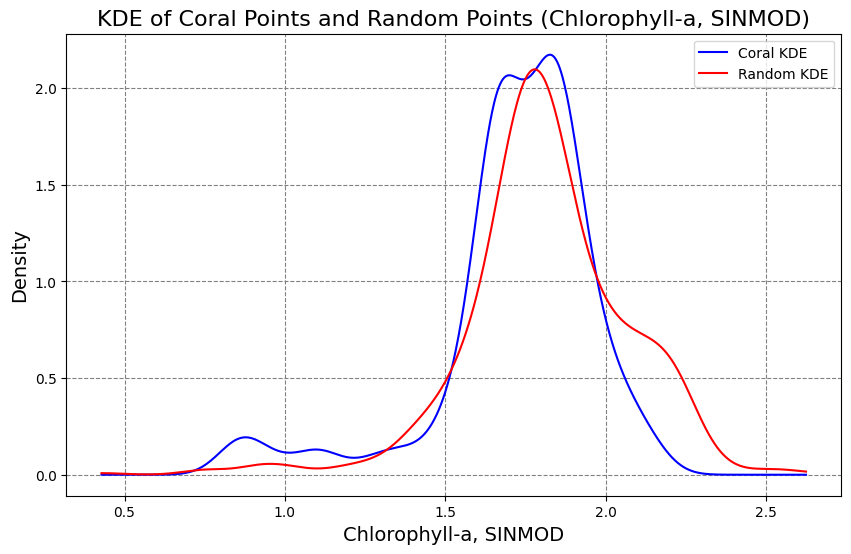

In [70]:
values_chlor_a_sinmod, random_values_chlor_a_sinmod = plot_histogram_at_coral_points_emod(chlor_a_sinmod_df_cleaned, coral_data_emod, 'chlor_a_features', True)